In [1313]:
import pandas as pd 
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [1314]:
metadata = pd.read_csv("../Project-Disney-World-DSF/metadata.csv")
hauntedhouse = pd.read_csv("../Project-Disney-World-DSF/haunted_mansion[87].csv")


In [1315]:
metadata

,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,01/01/2015,NaN,5,0,0,1,2015,CHRISTMAS PEAK,0,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,01/02/2015,NaN,6,1,0,1,2015,CHRISTMAS,2,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,01/03/2015,NaN,7,2,0,1,2015,CHRISTMAS,3,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,01/04/2015,NaN,1,3,1,1,2015,CHRISTMAS,4,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,01/05/2015,NaN,2,4,1,1,2015,CHRISTMAS,5,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,08/27/2021,NaN,6,238,34,8,2021,NaN,11,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2075,08/28/2021,NaN,7,239,34,8,2021,NaN,10,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2076,08/29/2021,NaN,1,240,35,8,2021,NaN,9,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2077,08/30/2021,NaN,2,241,35,8,2021,NaN,8,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [1316]:
hauntedhouse

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 08:23:09,NaN,-999.0
1,01/01/2015,2015-01-01 08:37:13,NaN,10.0
2,01/01/2015,2015-01-01 08:37:31,NaN,-999.0
3,01/01/2015,2015-01-01 08:44:11,NaN,10.0
4,01/01/2015,2015-01-01 08:51:12,NaN,10.0
...,...,...,...,...
319951,12/28/2021,2021-12-28 22:36:08,NaN,13.0
319952,12/28/2021,2021-12-28 22:42:15,NaN,13.0
319953,12/28/2021,2021-12-28 22:48:12,NaN,13.0
319954,12/28/2021,2021-12-28 22:54:10,NaN,13.0


**Preparing Hounted House Data**

In [1317]:
#compute percentage of na-values per column; result: 96.59% of actual waiting times are na
hauntedhouse.isna().mean()

date        0.000000
datetime    0.000000
SACTMIN     0.965973
SPOSTMIN    0.034027
dtype: float64

In [1318]:
#extract and drop SACTMIN column from Df
act_times = copy.deepcopy(hauntedhouse["SACTMIN"])
hauntedhouse = hauntedhouse.drop(["SACTMIN"], axis=1)

In [1319]:
#drop rows with missing waiting times (coded as -999)
hauntedhouse.loc[hauntedhouse['SPOSTMIN'] == -999,'SPOSTMIN'] = np.nan
hauntedhouse = hauntedhouse.dropna(axis=0, subset="SPOSTMIN")
hauntedhouse = hauntedhouse.reset_index(drop=True)
hauntedhouse       


,date,datetime,SPOSTMIN
0,01/01/2015,2015-01-01 08:37:13,10.0
1,01/01/2015,2015-01-01 08:44:11,10.0
2,01/01/2015,2015-01-01 08:51:12,10.0
3,01/01/2015,2015-01-01 09:02:13,15.0
4,01/01/2015,2015-01-01 09:09:16,20.0
...,...,...,...
293282,12/28/2021,2021-12-28 22:36:08,13.0
293283,12/28/2021,2021-12-28 22:42:15,13.0
293284,12/28/2021,2021-12-28 22:48:12,13.0
293285,12/28/2021,2021-12-28 22:54:10,13.0


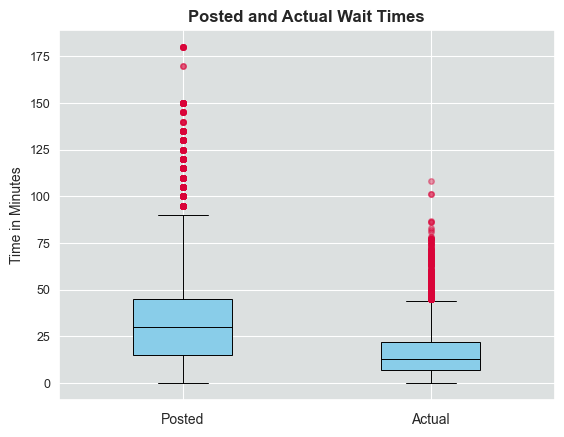

In [1320]:
#Boxplot of Actual and Posted Wait Times
arr_posted = hauntedhouse["SPOSTMIN"].to_numpy()
arr_actual = act_times.to_numpy()

#exclude outlier (1511.0) from arr_actual
arr_actual = arr_actual[(arr_actual < 1511.0)]
all_arr = [arr_posted, arr_actual]

sns.set(rc={'axes.facecolor':'#dce0e0'})

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'marker':'o', 'markerfacecolor':'#d90439', 'markersize':4, 'alpha':0.4, 'markeredgecolor':'#d90439'}
}

ax = sns.boxplot(data=all_arr, width = 0.4, color = "skyblue", saturation = 0.95,  linewidth = 0.7, **PROPS)
# for i,box in enumerate(ax.artists):
#     box.set_edgecolor('black')
ax.set_ylabel("Time in Minutes", fontsize=10)
ax.set_xticklabels(['Posted', 'Actual'], fontsize=10)
ax.set_title("Posted and Actual Wait Times", weight='bold')
ax.grid(linewidth=0.8)

plt.tick_params(axis='y', which='major', labelsize=9, pad=0)

#plt.savefig('Plot2', dpi=300)

plt.show()

In [1321]:
#format column datetime
hauntedhouse['datetime'] = pd.to_datetime(hauntedhouse['datetime'])

In [1322]:
#create additional variables
hauntedhouse["HOUROFDAY"] = hauntedhouse.copy()['datetime'].dt.hour
hauntedhouse["MINUTEOFHOUR"] = hauntedhouse.copy()['datetime'].dt.minute
hauntedhouse["YEAR"] = hauntedhouse.copy()['datetime'].dt.year
hauntedhouse["MONTHOFYEAR"] = hauntedhouse.copy()['datetime'].dt.month
hauntedhouse["DAYOFMONTH"] = hauntedhouse.copy()['datetime'].dt.day

In [1323]:
#create evenly spaced dataset: round waiting times to neareast ten minutes and aggregate
hauntedhouse["MINUTEOFHOUR"] = (hauntedhouse.copy()["MINUTEOFHOUR"]/10).round().astype(int) * 10
hauntedhouse = hauntedhouse.groupby(["YEAR", "MONTHOFYEAR", "DAYOFMONTH", "HOUROFDAY", "MINUTEOFHOUR"], as_index=False).agg(SPOSTMIN=('SPOSTMIN', 'mean'))
hauntedhouse

,YEAR,MONTHOFYEAR,DAYOFMONTH,HOUROFDAY,MINUTEOFHOUR,SPOSTMIN
0,2015,1,1,8,40,10.0
1,2015,1,1,8,50,10.0
2,2015,1,1,9,0,15.0
3,2015,1,1,9,10,20.0
4,2015,1,1,9,20,25.0
...,...,...,...,...,...,...
206460,2021,12,28,22,20,13.0
206461,2021,12,28,22,30,13.0
206462,2021,12,28,22,40,13.0
206463,2021,12,28,22,50,13.0


In [1324]:
#recreate 'date' and 'datetime' variables for easy, flexible access and merging later

hauntedhouse["datetime"] = pd.to_datetime(dict(year=hauntedhouse.YEAR, month=hauntedhouse.MONTHOFYEAR, day=hauntedhouse.DAYOFMONTH, hour=hauntedhouse.HOUROFDAY, minute=hauntedhouse.MINUTEOFHOUR))
hauntedhouse["date"] = hauntedhouse["YEAR"].map(str) + '-' + (np.where(hauntedhouse["MONTHOFYEAR"]<10, '0', '')) + hauntedhouse["MONTHOFYEAR"].map(str) + '-' +  (np.where(hauntedhouse["DAYOFMONTH"]<10, '0', '')) + hauntedhouse["DAYOFMONTH"].map(str)
hauntedhouse['date'] = pd.to_datetime(hauntedhouse['date'])


In [1325]:
hauntedhouse

,YEAR,MONTHOFYEAR,DAYOFMONTH,HOUROFDAY,MINUTEOFHOUR,SPOSTMIN,datetime,date
0,2015,1,1,8,40,10.0,2015-01-01 08:40:00,2015-01-01
1,2015,1,1,8,50,10.0,2015-01-01 08:50:00,2015-01-01
2,2015,1,1,9,0,15.0,2015-01-01 09:00:00,2015-01-01
3,2015,1,1,9,10,20.0,2015-01-01 09:10:00,2015-01-01
4,2015,1,1,9,20,25.0,2015-01-01 09:20:00,2015-01-01
...,...,...,...,...,...,...,...,...
206460,2021,12,28,22,20,13.0,2021-12-28 22:20:00,2021-12-28
206461,2021,12,28,22,30,13.0,2021-12-28 22:30:00,2021-12-28
206462,2021,12,28,22,40,13.0,2021-12-28 22:40:00,2021-12-28
206463,2021,12,28,22,50,13.0,2021-12-28 22:50:00,2021-12-28


Data Exploration

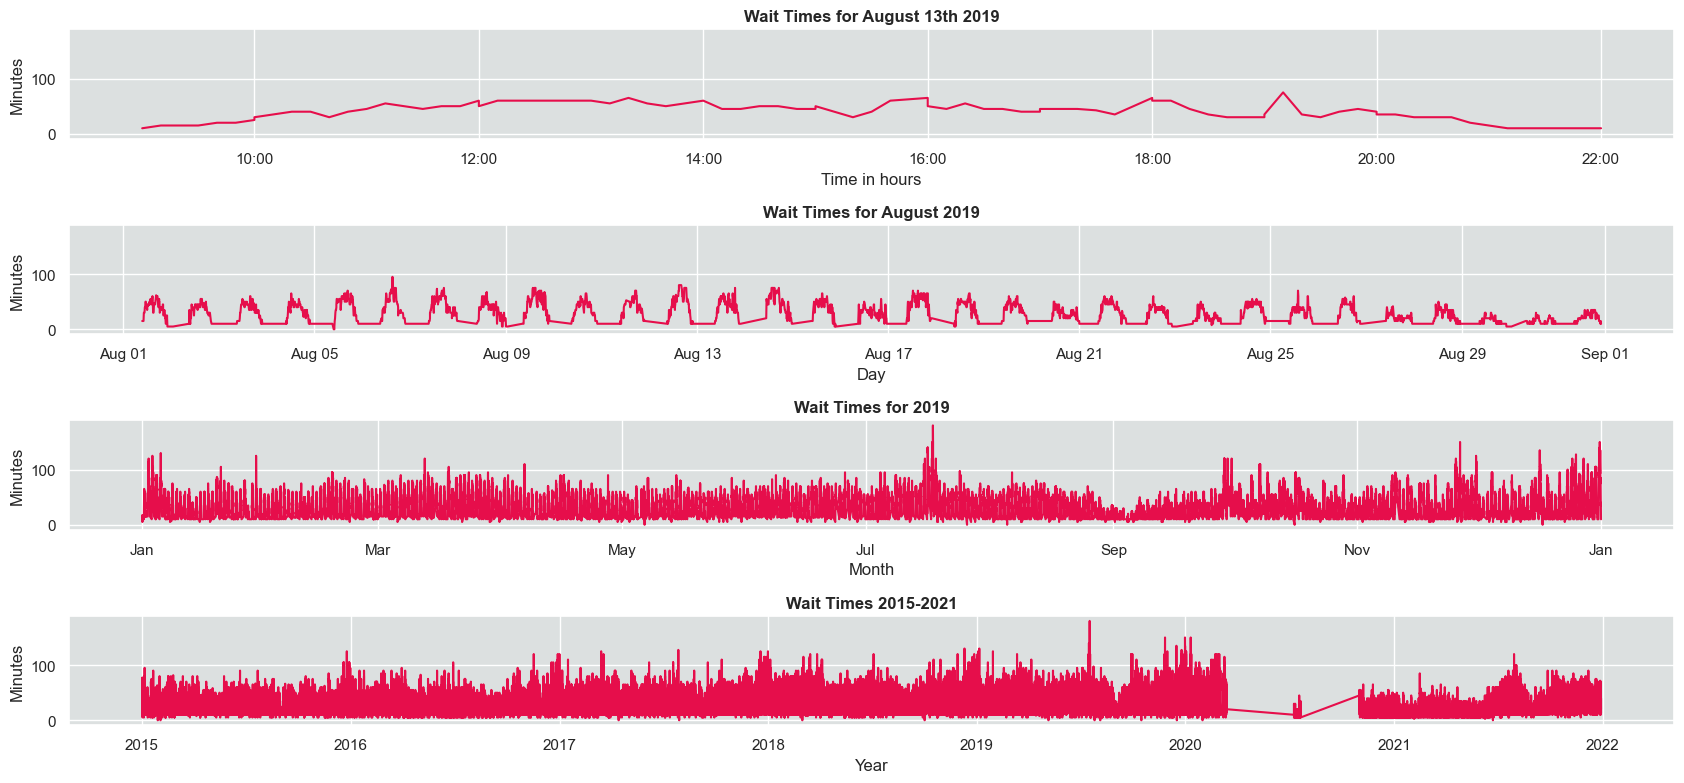

In [1326]:
#plot wait times
summer_month = hauntedhouse.loc[(hauntedhouse["MONTHOFYEAR"]==8) & (hauntedhouse["YEAR"]==2019)] 

summer_day = hauntedhouse.loc[hauntedhouse["date"]=='08/13/2019'] 
year2019 = hauntedhouse.loc[hauntedhouse["YEAR"]==2019] 

fig, axs = plt.subplots(4, figsize=(17,8), sharey=True)
axs[0].plot(summer_day["datetime"], summer_day["SPOSTMIN"], color='#e60e4b')
axs[0].set_title("Wait Times for August 13th 2019", weight='bold')
axs[0].set_ylabel("Minutes")
axs[0].set_xlabel("Time in hours")

date_form1 = DateFormatter("%H:%M")
axs[0].xaxis.set_major_formatter(date_form1)

axs[1].plot(summer_month["datetime"], summer_month["SPOSTMIN"], color='#e60e4b')
axs[1].set_title("Wait Times for August 2019", weight='bold')
axs[1].set_ylabel("Minutes")
axs[1].set_xlabel("Day")

date_form2 = DateFormatter("%b %d")
axs[1].xaxis.set_major_formatter(date_form2)

axs[2].plot(year2019["datetime"], year2019["SPOSTMIN"], color='#e60e4b')
axs[2].set_title("Wait Times for 2019", weight='bold')
axs[2].set_ylabel("Minutes")
axs[2].set_xlabel("Month")

date_form3 = DateFormatter("%b")
axs[2].xaxis.set_major_formatter(date_form3)

axs[3].plot(hauntedhouse["datetime"], hauntedhouse["SPOSTMIN"], color='#e60e4b')
axs[3].set_title("Wait Times 2015-2021", weight='bold')
axs[3].set_ylabel("Minutes")
axs[3].set_xlabel("Year")

plt.tight_layout()
plt.savefig('Plot1.png')

Text(0.5, 0, 'Year')

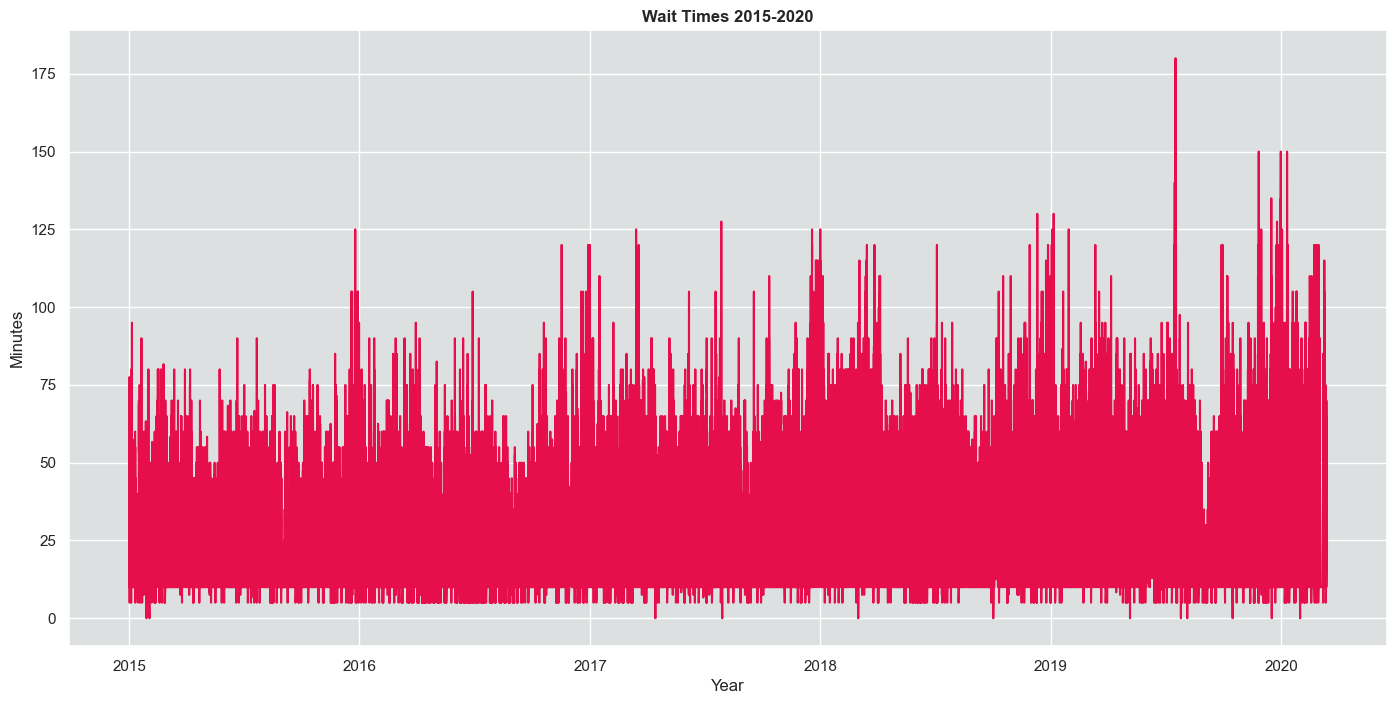

In [1327]:
#only keep datapoints from before the pandemic
hauntedhouse = hauntedhouse.loc[hauntedhouse['datetime']<=datetime.datetime(2020,3,13,23,0,0)]
fig, ax = plt.subplots(figsize=(17,8))

ax.plot(hauntedhouse["datetime"], hauntedhouse["SPOSTMIN"], color='#e60e4b')
ax.set_title("Wait Times 2015-2020", weight='bold')
ax.set_ylabel("Minutes")
ax.set_xlabel("Year")

#plt.savefig('Plot2015-2020', dpi=300)


**Preparing Metadata**

In [1328]:
#remove variables related to Hollywood Studios Park in California (and not Walt Disney World in Florida)
metadata.columns.str.startswith('HS').sum() 
metadata.columns.str.endswith('_HS').sum() 

metadata = metadata.loc[:, ~metadata.columns.str.startswith('HS')]
metadata = metadata.loc[:, ~metadata.columns.str.endswith('_HS')]

metadata.shape

(2079, 145)

In [1329]:
#looking at percentage of na-values per column
metadata.isna().mean().sort_values(ascending=False).head(20)

AKPRDDT2     1.000000
AKFIREN      1.000000
AKPRDDT1     1.000000
AKPRDDN      1.000000
EPFIRET2     0.997595
MKFIRET2     0.995190
HOLIDAYJ     0.979798
AKeventN     0.966811
WDWRaceN     0.958153
HOLIDAYN     0.897066
MKPRDDT2     0.890332
WDWeventN    0.881193
MKeventN     0.743627
MKPRDNT2     0.711881
MKPRDNN      0.653199
MKPRDNT1     0.653199
AKSHWNT2     0.552670
AKSHWNN      0.424723
AKSHWNT1     0.424723
EPeventN     0.417508
dtype: float64

In [1330]:
#filter out columns with all na-values
metadata.dropna(axis=1, how='all', inplace=True)

#format date
metadata['DATE'] = pd.to_datetime(metadata['DATE'])

metadata.shape

(2079, 141)

In [1331]:
#drop redundant columns
metadata = metadata.loc[:, metadata.columns != "MONTHOFYEAR"]
metadata = metadata.loc[:, metadata.columns != "YEAR"]

In [1332]:
#function that deals with string percentage values (e.g. '70%') for columns that contain percentage of schools in session
def str_percent_to_float(dataframe):
    for col in dataframe.columns:
        if col.lower().startswith('insession'):
            dataframe[col] = dataframe[col].str.rstrip("%").astype(float)/100
            
str_percent_to_float(metadata)
metadata

,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,HOLIDAY,...,MKFIREN,EPFIREWK,EPFIRET1,EPFIRET2,EPFIREN,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,2015-01-01,NaN,5,0,0,CHRISTMAS PEAK,0,5,nyd,1,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
1,2015-01-02,NaN,6,1,0,CHRISTMAS,2,5,NaN,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
2,2015-01-03,NaN,7,2,0,CHRISTMAS,3,0,NaN,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
3,2015-01-04,NaN,1,3,1,CHRISTMAS,4,0,NaN,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
4,2015-01-05,NaN,2,4,1,CHRISTMAS,5,0,NaN,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,2021-08-27,NaN,6,238,34,NaN,11,0,NaN,0,...,Happily Ever After,1,22:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN
2075,2021-08-28,NaN,7,239,34,NaN,10,0,NaN,0,...,Happily Ever After,1,22:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN
2076,2021-08-29,NaN,1,240,35,NaN,9,0,NaN,0,...,Happily Ever After,1,22:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN
2077,2021-08-30,NaN,2,241,35,NaN,8,0,NaN,0,...,Happily Ever After,1,21:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN


In [1333]:
#function that deals with string times of form '9:00' or '25:00'; converts to hours since midnight (float) for consistency and usability
cols = ["MKOPEN", "MKCLOSE", "MKEMHOPEN", "MKEMHCLOSE", "MKOPENYEST", "MKCLOSEYEST", "MKOPENTOM", "MKCLOSETOM", "EPOPEN", "EPCLOSE", "EPEMHOPEN",
"EPEMHCLOSE", "EPOPENYEST", "EPCLOSEYEST", "EPOPENTOM", "EPCLOSETOM", "AKOPEN", "AKCLOSE", "AKEMHOPEN", "AKEMHCLOSE", "AKOPENYEST", "AKCLOSEYEST",
"AKOPENTOM", "AKCLOSETOM", "MKPRDDT1", "MKPRDDT2", "MKPRDNT1", "MKPRDNT2", "MKFIRET1", "MKFIRET2", "EPFIRET1", "EPFIRET2", "AKSHWNT1", "AKSHWNT2"]

for col in cols:
    metadata[col].fillna("99", inplace=True)  #replace na with '99' to indicate outliers; e.g. when a second firework (MKFIRET2) is not taking place that day 



In [1334]:
def format_times(x):
    if len(x)==4:
        time = '0'+ x
    elif len(x)==5 and x > '24:00':
        hour = int(x[:2])-24
        minute = x[-2:]
        time = '0' + str(hour) + ':' + minute
    elif x == '24:00':
        time = '00:00'
    else:
        time = x
    return time

def str_times_to_numerical(dataframe):
    for col in cols:
        dataframe[col] = dataframe[col].apply(format_times)
        dataframe[col] = dataframe[col].apply(lambda y: y.rstrip(':'))
        dataframe[col] = dataframe[col].apply(lambda x: (float(x[:2])+(float(x[-2:])/60)) if x[0] != 0 else (float(x[1])+(float(x[-2:])/60)))

str_times_to_numerical(metadata)


In [1335]:
#one-hot encoding of categorical features
categorical_features = ["WDW_TICKET_SEASON", "SEASON", "HOLIDAYN", "WDWTICKETSEASON", "WDWRaceN", "WDWeventN", "WDWSEASON", "MKeventN", "EPeventN", "AKeventN", "HOLIDAYJ", "MKPRDDN", "MKPRDNN", "MKFIREN", "EPFIREN", "AKSHWNN"]

transformer = make_column_transformer(
    (OneHotEncoder(), categorical_features),
    remainder='passthrough')

transformed = transformer.fit_transform(metadata)
encoded_metadata = pd.DataFrame(transformed, columns=transformer.get_feature_names())
#new name of columns for i encoded column: 'onehotencoder__xi_oldcategoryname'


encoded_metadata.shape


c:\Users\Sara Knapp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(2079, 275)

In [1336]:
#function for filling missing values, to be used at later time
def imputation(dataframe):
        for col in dataframe.columns:
                dataframe[col] = dataframe[col].fillna(method='bfill')
                dataframe[col] = dataframe[col].fillna(dataframe[col].median())
        return dataframe

Merge datasets

In [1337]:
#change name of "DATE" column in metadata to fit with Haunted House 
encoded_metadata.rename(columns={"DATE":"date"}, inplace=True)

In [1338]:
#merge metadata and waiting time data 
waittimes = pd.merge(hauntedhouse, encoded_metadata, how='left', on='date')

In [1339]:
#drop redundant time columns
waittimes = waittimes.loc[:, waittimes.columns != "date"]
waittimes = waittimes.loc[:, waittimes.columns != "DAYOFWEEK"]
waittimes = waittimes.loc[:, waittimes.columns != "DAYOFYEAR"]
waittimes = waittimes.loc[:, waittimes.columns != "WEEKOFYEAR"]
waittimes


,YEAR,MONTHOFYEAR,DAYOFMONTH,HOUROFDAY,MINUTEOFHOUR,SPOSTMIN,datetime,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,...,MKFIREWK,MKFIRET1,MKFIRET2,EPFIREWK,EPFIRET1,EPFIRET2,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2
0,2015,1,1,8,40,10.0,2015-01-01 08:40:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
1,2015,1,1,8,50,10.0,2015-01-01 08:50:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
2,2015,1,1,9,0,15.0,2015-01-01 09:00:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
3,2015,1,1,9,10,20.0,2015-01-01 09:10:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
4,2015,1,1,9,20,25.0,2015-01-01 09:20:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174016,2020,3,13,21,20,20.0,2020-03-13 21:20:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,1,20.25,100.65
174017,2020,3,13,21,30,30.0,2020-03-13 21:30:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,1,20.25,100.65
174018,2020,3,13,21,40,30.0,2020-03-13 21:40:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,1,20.25,100.65
174019,2020,3,13,21,50,30.0,2020-03-13 21:50:00,0.0,0.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,1,20.25,100.65


**Predictive Models**

In [1340]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import SplineTransformer
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter
import matplotlib.colors
from math import sqrt
import calendar

In [1341]:
#impute missing values
waittimes = imputation(waittimes)

<AxesSubplot: xlabel='SPOSTMIN', ylabel='Count'>

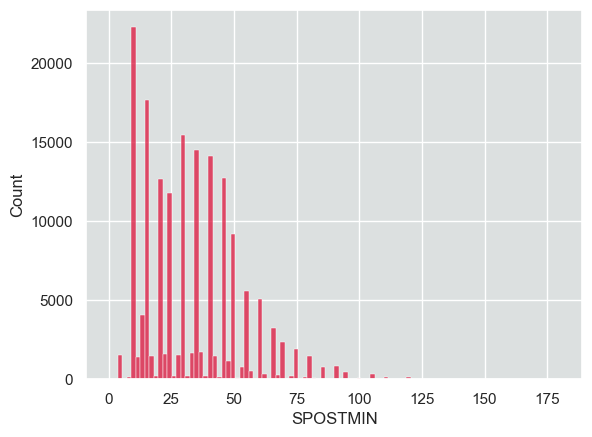

In [1342]:
#Plot count of each wait time to see distribution
sns.histplot(waittimes["SPOSTMIN"], color="crimson", bins=100)

Split into Training and Testing Sets

In [1343]:
X = waittimes.loc[:, waittimes.columns != "SPOSTMIN"]
X = X.loc[:, X.columns != "datetime"]
y = np.array(waittimes["SPOSTMIN"])
X.shape, y.shape

((174021, 276), (174021,))

In [1344]:
ts_cv = TimeSeriesSplit(
    n_splits=3,
    test_size = int(0.2*len(X))
)
#inspect the first split
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]


,YEAR,MONTHOFYEAR,DAYOFMONTH,HOUROFDAY,MINUTEOFHOUR,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,onehotencoder__x0_nan,onehotencoder__x1_CHRISTMAS,...,MKFIREWK,MKFIRET1,MKFIRET2,EPFIREWK,EPFIRET1,EPFIRET2,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2
69609,2017,3,5,17,60,0.0,0.0,1.0,0.0,0.0,...,1,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5
69610,2017,3,5,18,0,0.0,0.0,1.0,0.0,0.0,...,1,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5
69611,2017,3,5,18,10,0.0,0.0,1.0,0.0,0.0,...,1,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5
69612,2017,3,5,18,20,0.0,0.0,1.0,0.0,0.0,...,1,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5
69613,2017,3,5,18,30,0.0,0.0,1.0,0.0,0.0,...,1,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104408,2018,3,18,19,10,1.0,0.0,0.0,0.0,0.0,...,1,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0
104409,2018,3,18,19,20,1.0,0.0,0.0,0.0,0.0,...,1,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0
104410,2018,3,18,19,30,1.0,0.0,0.0,0.0,0.0,...,1,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0
104411,2018,3,18,19,40,1.0,0.0,0.0,0.0,0.0,...,1,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0


In [1345]:
X.iloc[train_0]

,YEAR,MONTHOFYEAR,DAYOFMONTH,HOUROFDAY,MINUTEOFHOUR,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,onehotencoder__x0_nan,onehotencoder__x1_CHRISTMAS,...,MKFIREWK,MKFIRET1,MKFIRET2,EPFIREWK,EPFIRET1,EPFIRET2,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2
0,2015,1,1,8,40,0.0,0.0,0.0,1.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
1,2015,1,1,8,50,0.0,0.0,0.0,1.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
2,2015,1,1,9,0,0.0,0.0,0.0,1.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
3,2015,1,1,9,10,0.0,0.0,0.0,1.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
4,2015,1,1,9,20,0.0,0.0,0.0,1.0,0.0,...,1,21.0,100.65,1,21.0,100.65,0,0,100.65,100.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69604,2017,3,5,17,10,0.0,0.0,1.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,19.25,20.50
69605,2017,3,5,17,20,0.0,0.0,1.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,19.25,20.50
69606,2017,3,5,17,30,0.0,0.0,1.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,19.25,20.50
69607,2017,3,5,17,40,0.0,0.0,1.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,19.25,20.50


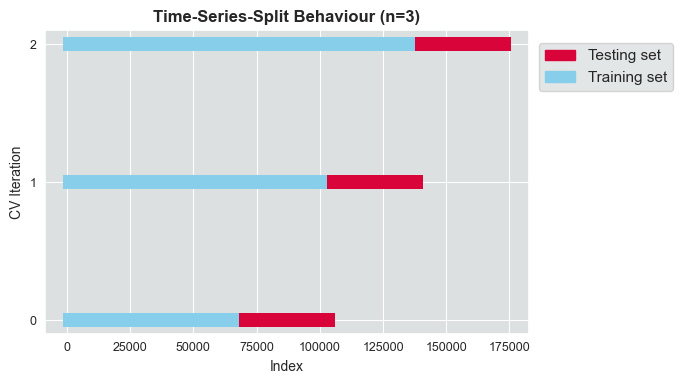

In [1346]:
#Plot Time Series Split behaviour
n_splits = 3
cmap_cv = matplotlib.colors.ListedColormap(['#87ceeb', '#d90439'])

fig, ax = plt.subplots(figsize=(7, 4))
   
for ii, (tr, tt) in enumerate(ts_cv.split(X=X, y=y)):
    indices = np.array([np.nan] * len(X))
    indices[tt] = 1
    indices[tr] = 0

    ax.scatter(
         range(len(indices)),
         [ii] * len(indices),
         c=indices, marker="_", linewidths = 10, cmap = cmap_cv)

yticklabels = list(range(n_splits))
ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels)

ax.legend(
        [Patch(color='#d90439'), Patch(color='#87ceeb')],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
ax.set_title('Time-Series-Split Behaviour (n=3)', weight='bold')
ax.set_xlabel("Index", fontsize=10)
ax.set_ylabel("CV Iteration", fontsize=10)
ax.grid(linewidth=0.8)

plt.tick_params(axis='both', which='major', labelsize=9, pad=0)
plt.tight_layout()
#plt.savefig('Plot3.png', dpi=300)

Random Forest

In [1347]:
rf_pipe = Pipeline(
   [('random_forest', RandomForestRegressor(n_estimators=15, max_depth=70, random_state=42))]
)

rf_pipe.fit(X.iloc[train_0], y[train_0])
preds_rf = rf_pipe.predict(X.iloc[test_0])

#error on first CV split
sqrt(mean_squared_error(y[test_0], preds_rf))

13.741668873041345

In [1348]:
#function that plots posted wait times and predictions for a specific day
#expects integer lists of date variables and integer dimensions of the figure as input

def plot_results (years, months, days, nrows, ncols, preds):

    fig, axs = plt.subplots(nrows, ncols, figsize=(12,8), sharey = True)
    if len(years) % 2 != 0:
        fig.delaxes(axs.ravel()[-1])
        
    for date in range(len(years)):
        rows = X.iloc[test_0].loc[(X["YEAR"]==years[date]) & (X["MONTHOFYEAR"]==months[date]) & (X["DAYOFMONTH"]==days[date])]
        rows_reset = X.iloc[test_0].reset_index()
        rows_reset = rows_reset.loc[(rows_reset["YEAR"]==years[date]) & (rows_reset["MONTHOFYEAR"]==months[date]) & (rows_reset["DAYOFMONTH"]==days[date])]
        rows_reset_indeces = rows_reset.index.tolist()
        indeces_test0 = rows.index.tolist()

        axs.ravel()[date].plot(waittimes.iloc[indeces_test0]["datetime"], y[indeces_test0], label = "Posted", color='#013163')
        axs.ravel()[date].plot(waittimes.iloc[indeces_test0]["datetime"], preds[rows_reset_indeces], color='#a6033f', label="Prediction")
        axs.ravel()[date].set_ylabel("Minutes")
        axs.ravel()[date].set_xlabel("Hours")
        axs.ravel()[date].set_title(f'{calendar.month_name[months[date]]} {days[date]}st {years[date]}' if days[date]==1 else f'{calendar.month_name[months[date]]} {days[date]}rd {years[date]}' if days[date] in [3, 23] else f'{calendar.month_name[months[date]]} {days[date]}nd {years[date]}' if days[date] in [2, 22] else f'{calendar.month_name[months[date]]} {days[date]}th {years[date]}', weight='bold')
        axs.ravel()[date].legend()

        date_form = DateFormatter("%H:%M")
        axs.ravel()[date].xaxis.set_major_formatter(date_form)
    plt.suptitle("Comparison of Posted Wait Times and Prediction", weight='bold')
    plt.tight_layout()
    plt.savefig("PlotPreds")
    plt.show()



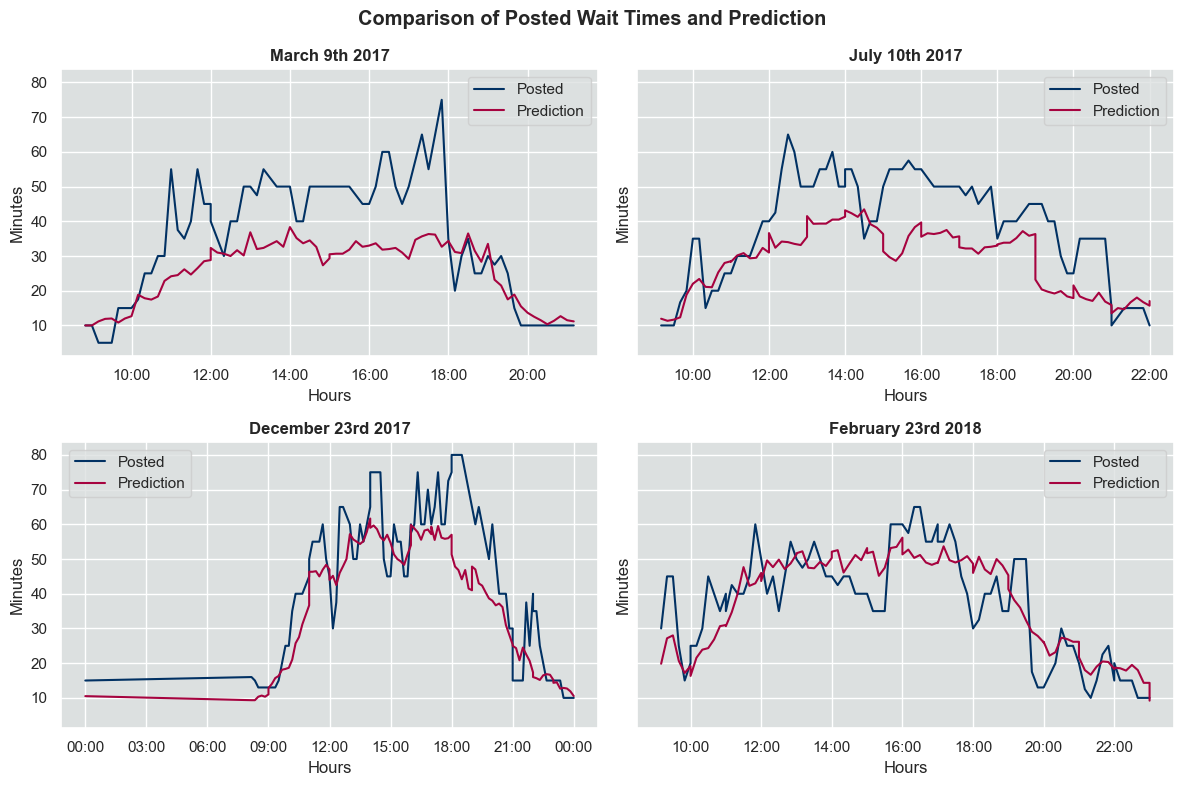

In [1349]:
plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_rf)


Cross Validation

In [1350]:
#function for cross validation
def evaluate (model, X, y, cv):
    cv_results = cross_validate(
        model, X, y, cv=cv, scoring= ["r2", "neg_root_mean_squared_error"],  
    )
    r_squared = -cv_results["test_r2"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"R_squared:   {r_squared.mean():.3f} +/- {r_squared.std():.3f}\n"
        f"RMSE:        {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [1351]:
evaluate(rf_pipe, X, y, cv=ts_cv)

R_squared:   -0.519 +/- 0.025
RMSE:        14.106 +/- 0.939


Boosted Trees

In [1352]:
boost_pipe = Pipeline(
   [('boost', HistGradientBoostingRegressor(random_state= 42))]
)

boost_pipe.fit(X.iloc[train_0], y[train_0])
preds_boost = boost_pipe.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0], preds_boost))

12.497808844357149

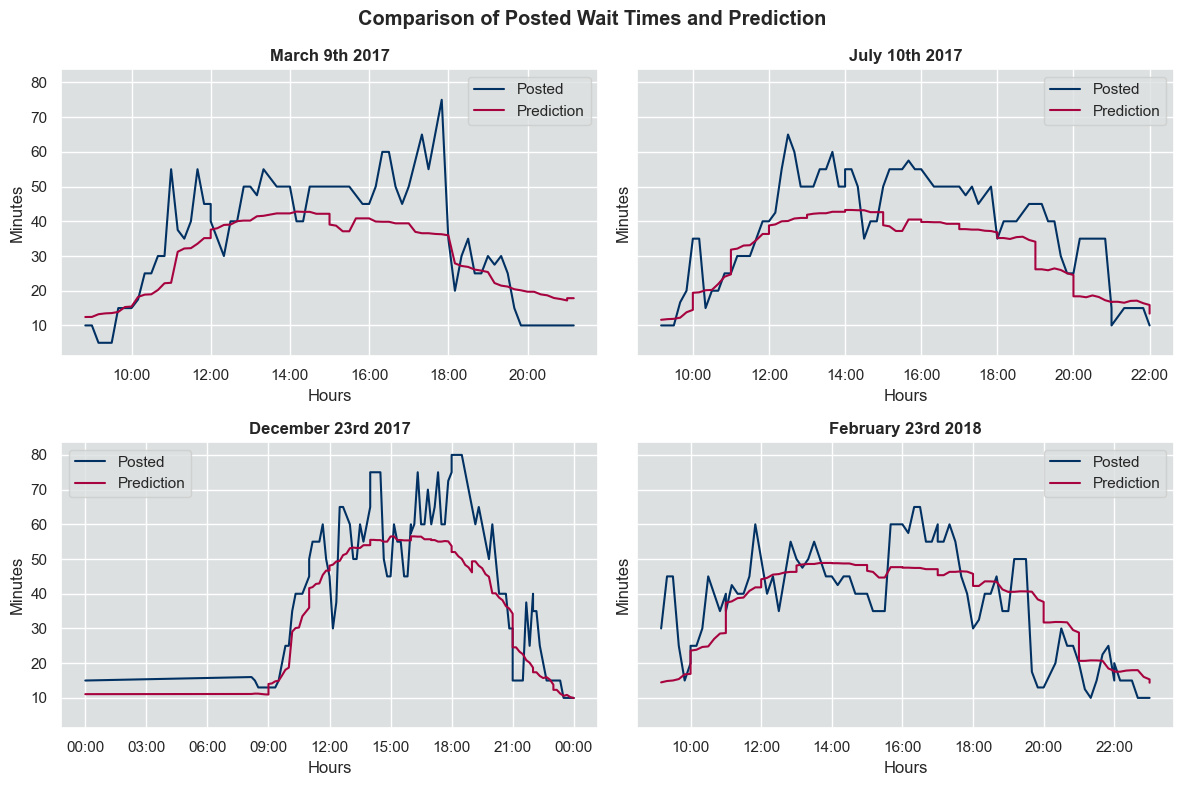

In [1353]:
plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_boost)

In [1354]:
#Cross Validation
evaluate(boost_pipe, X, y, cv=ts_cv)

R_squared:   -0.601 +/- 0.035
RMSE:        12.869 +/- 1.267


Linear Regression

In [1355]:
lr_pipe = Pipeline(
   [('linear', LinearRegression())]
)


In [1356]:
lr_pipe.fit(X.iloc[train_0], y[train_0])
preds_lr = lr_pipe.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0],preds_lr))

86.22252825769249

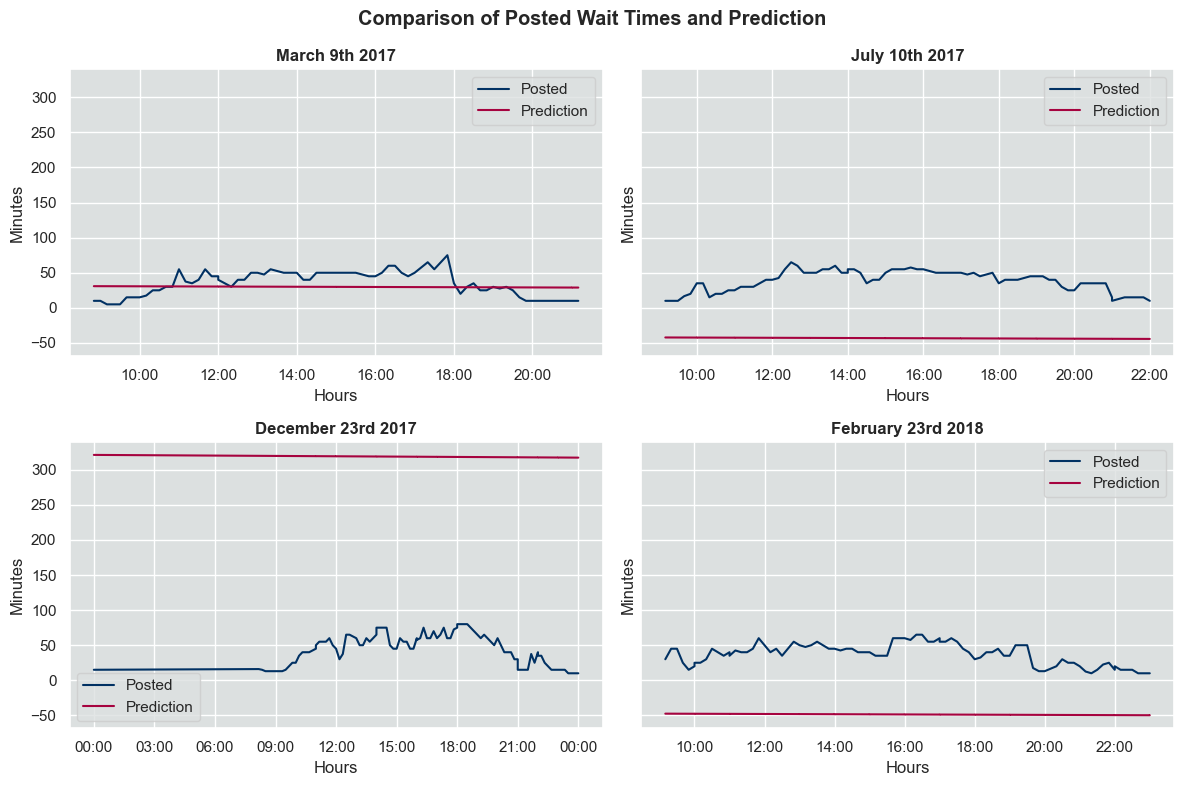

In [1357]:
plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_lr)

In [1358]:
#Cross Validation
evaluate(lr_pipe, X, y, cv=ts_cv)

R_squared:   12.753 +/- 8.937
RMSE:        68.957 +/- 34.649


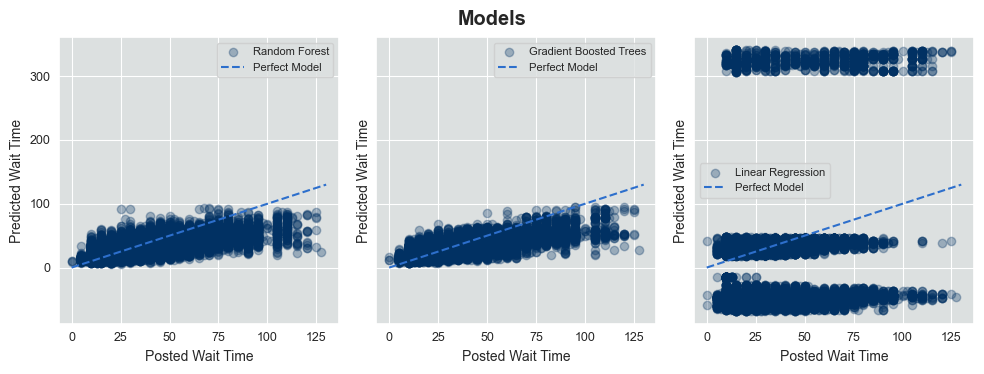

In [1359]:
#Plot prediction error: posted vs predicted wait time
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
fig.suptitle("Models", weight='bold', y=0.93)
predictions = [preds_rf, preds_boost, preds_lr]

labels = ["Random Forest", "Gradient Boosted Trees", "Linear Regression"]

for ax, pred, label in zip(axes, predictions, labels):
    ax.tick_params(axis='both', which='major', labelsize=9, pad=0)
    ax.scatter(y[test_0], pred, alpha=0.3, label=label, color='#013163', edgecolors=None)
    ax.plot([0, 130], [0, 130], "--", label="Perfect Model", color='#2d6fcc')
    ax.set_xlabel("Posted Wait Time", fontsize=10)
    ax.set_ylabel("Predicted Wait Time", fontsize=10)
    ax.grid(linewidth=0.8)
    ax.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('Plot4.png', dpi=300)
plt.show()

**Time Feature Engineering**

One-Hot Encoding of Time Features

In [1360]:
time_columns = ["MONTHOFYEAR", "DAYOFMONTH", "HOUROFDAY", "MINUTEOFHOUR"]
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

one_hot_transformer = ColumnTransformer(
    transformers=[
        ("one_hot", one_hot_encoder, time_columns),
    ], 
)

lr_pipe6 = Pipeline(
   [('one_hot', one_hot_transformer), ('linear', LinearRegression())]
)

lr_pipe6.fit(X.iloc[train_0], y[train_0])
preds_lr6 = lr_pipe6.predict(X.iloc[test_0])
evaluate(lr_pipe6, X, y, cv=ts_cv)


R_squared:   -0.333 +/- 0.041
RMSE:        16.631 +/- 1.323


In [1361]:
#plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_lr6)

In [1362]:
rf_pipe6 = Pipeline(
   [('one_hot', one_hot_transformer), ('random_forest', RandomForestRegressor(n_estimators=15, max_depth=70, random_state=42))]
)

rf_pipe6.fit(X.iloc[train_0], y[train_0])
preds_rf6 = rf_pipe6.predict(X.iloc[test_0])
evaluate(rf_pipe6, X, y, cv=ts_cv)

R_squared:   -0.312 +/- 0.047
RMSE:        16.864 +/- 1.146


In [1363]:
boost_pipe6 = Pipeline(
   [('one_hot', one_hot_transformer),('boost', HistGradientBoostingRegressor(random_state= 42))]
)

boost_pipe6.fit(X.iloc[train_0], y[train_0])
preds_boost6 = boost_pipe6.predict(X.iloc[test_0])
evaluate(boost_pipe6, X, y, cv=ts_cv)

R_squared:   -0.382 +/- 0.041
RMSE:        16.005 +/- 1.288


Sine and Cosine Transformation of Time Features

In [1364]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [1365]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("month_sin", sin_transformer(12), ["MONTHOFYEAR"]),
        ("month_cos", cos_transformer(12), ["MONTHOFYEAR"]),
        ("day_sin", sin_transformer(30), ["DAYOFMONTH"]),
        ("day_cos", cos_transformer(30), ["DAYOFMONTH"]),
        ("hour_sin", sin_transformer(24), ["HOUROFDAY"]),
        ("hour_cos", cos_transformer(24), ["HOUROFDAY"]),
        ("min_sin", sin_transformer(7), ["MINUTEOFHOUR"]),
        ("min_cos", cos_transformer(7), ["MINUTEOFHOUR"]),
    ],
)

Linear Regression

In [1366]:
lr_pipe2 = Pipeline(
   [('cyclic', cyclic_cossin_transformer),('linear', LinearRegression())]
)

lr_pipe2.fit(X.iloc[train_0], y[train_0])
preds_lr2 = lr_pipe2.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0],preds_lr2))

16.775638140952875

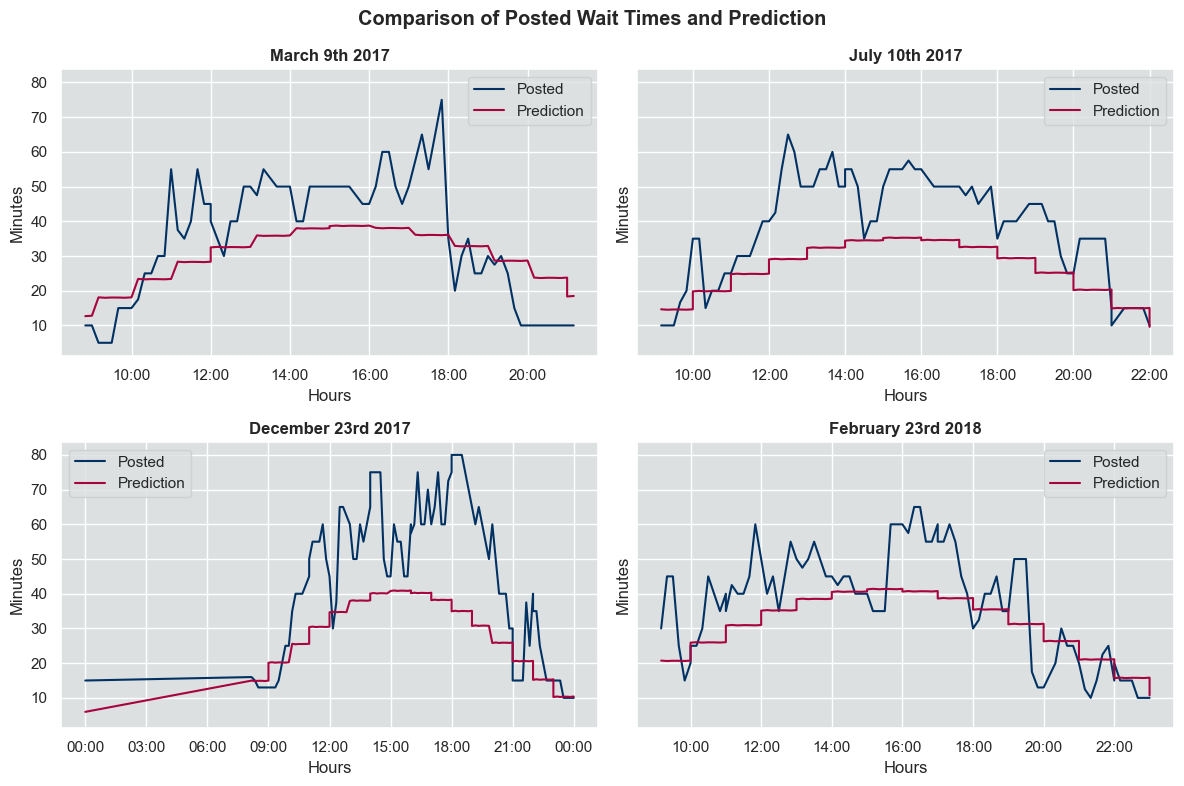

In [1367]:
plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_lr2)

In [1368]:
evaluate(lr_pipe2, X, y, cv=ts_cv)

R_squared:   -0.276 +/- 0.034
RMSE:        17.324 +/- 1.266


Random Forest

In [1369]:
rf_pipe2 = Pipeline(
   [('cyclic', cyclic_cossin_transformer), ('random_forest', RandomForestRegressor(n_estimators=15, max_depth=70, random_state=42))]
)

rf_pipe2.fit(X.iloc[train_0], y[train_0])
preds_rf2 = rf_pipe2.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0], preds_rf2))

16.680970209016532

In [1370]:
#plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_rf2)

In [1371]:
evaluate(rf_pipe2, X, y, cv=ts_cv)

R_squared:   -0.306 +/- 0.048
RMSE:        16.940 +/- 1.181


Boosted Trees

In [1372]:
boost_pipe2 = Pipeline(
   [('cyclic', cyclic_cossin_transformer), ('boost', HistGradientBoostingRegressor(random_state= 42))]
)

boost_pipe2.fit(X.iloc[train_0], y[train_0])
preds_boost2 = boost_pipe2.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0], preds_boost2))

15.410650173558679

In [1373]:
#plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_boost2)

In [1374]:
evaluate(boost_pipe2, X, y, cv=ts_cv)

R_squared:   -0.395 +/- 0.038
RMSE:        15.836 +/- 1.281


Periodic spline features

In [1375]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [1376]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["MONTHOFYEAR"]),
        ("cyclic_day", periodic_spline_transformer(30, n_splines=3), ["DAYOFMONTH"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["HOUROFDAY"]),
        ("cyclic_minute", periodic_spline_transformer(7, n_splines=12), ["MINUTEOFHOUR"]),

    ],
)

Linear Regression

In [1377]:
lr_pipe3 = Pipeline(
   [('spline', cyclic_spline_transformer),('linear', LinearRegression())]
)

lr_pipe3.fit(X.iloc[train_0], y[train_0])
preds_lr3 = lr_pipe3.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0],preds_lr3))


16.507853011398563

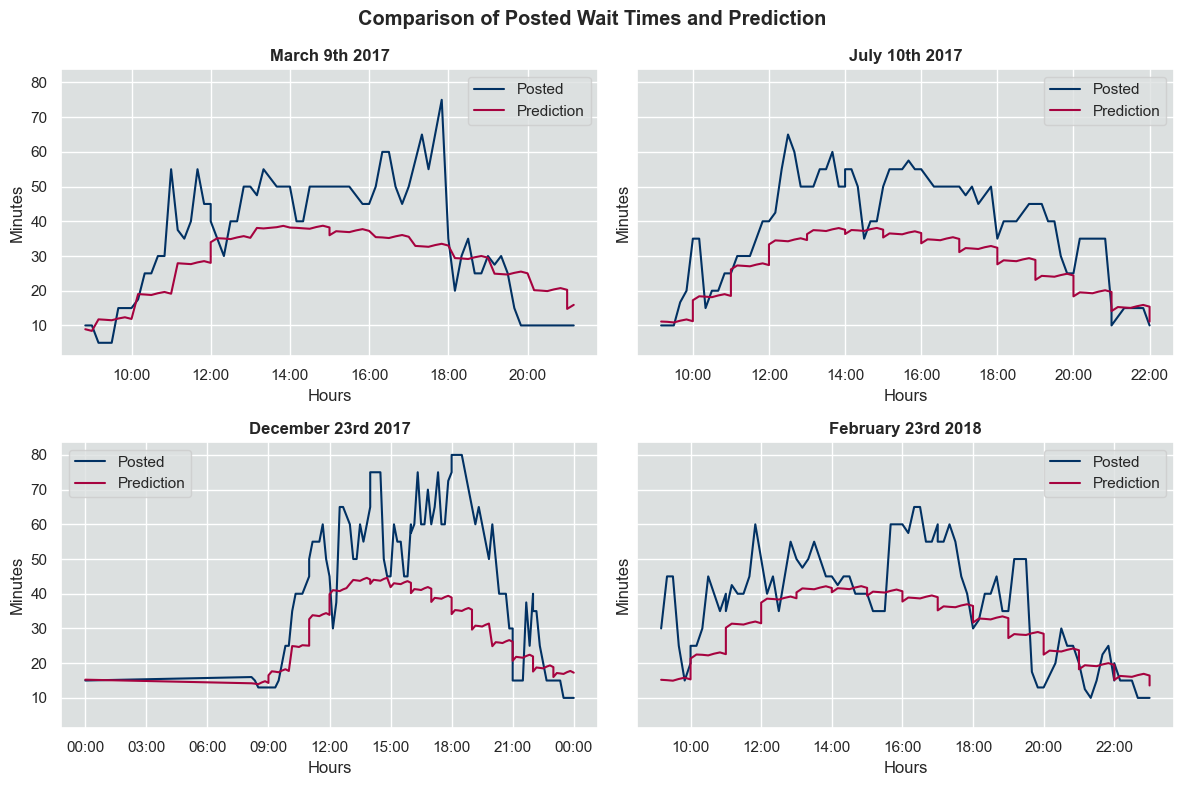

In [1378]:
plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_lr3)

In [1379]:
evaluate(lr_pipe3, X, y, cv=ts_cv)

R_squared:   -0.310 +/- 0.043
RMSE:        16.902 +/- 1.263


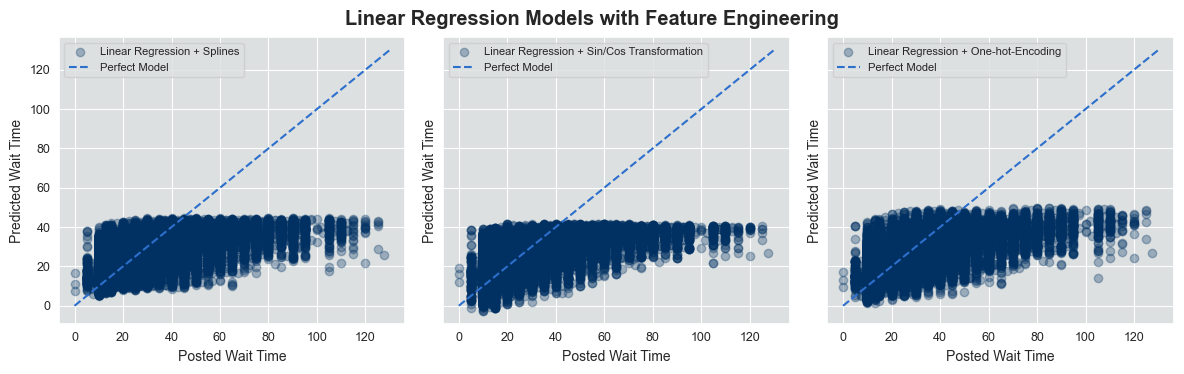

In [1380]:
#Plot prediction error: posted vs predicted wait time
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Linear Regression Models with Feature Engineering", weight='bold', y=0.93)
predictions = [preds_lr3, preds_lr2, preds_lr6]

labels = ["Linear Regression + Splines", "Linear Regression + Sin/Cos Transformation", "Linear Regression + One-hot-Encoding"]

for ax, pred, label in zip(axes, predictions, labels):
    ax.tick_params(axis='both', which='major', labelsize=9, pad=0)
    ax.scatter(y[test_0], pred, alpha=0.3, label=label, color='#013163', edgecolors=None)
    ax.plot([0, 130], [0, 130], "--", label="Perfect Model", color='#2d6fcc')
    ax.set_xlabel("Posted Wait Time", fontsize=10)
    ax.set_ylabel("Predicted Wait Time", fontsize=10)
    ax.grid(linewidth=0.8)
    ax.legend(fontsize=8)

plt.tight_layout()
#plt.savefig('Plot4.png', dpi=300)
plt.show()

Random Forest

In [1381]:
rf_pipe3 = Pipeline(
   [('spline', cyclic_spline_transformer), ('random_forest', RandomForestRegressor(n_estimators=15, max_depth=70, random_state=42))]
)

rf_pipe3.fit(X.iloc[train_0], y[train_0])
preds_rf3 = rf_pipe3.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0], preds_rf3))

16.67472742468456

In [1382]:
#plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_rf3)

In [1383]:
evaluate(rf_pipe3, X, y, cv=ts_cv)

R_squared:   -0.306 +/- 0.048
RMSE:        16.939 +/- 1.183


Boosted Trees

In [1384]:
boost_pipe3 = Pipeline(
   [('spline', cyclic_spline_transformer), ('boost', HistGradientBoostingRegressor(random_state= 42))]
)

boost_pipe3.fit(X.iloc[train_0], y[train_0])
preds_boost3 = boost_pipe3.predict(X.iloc[test_0])
#error on first CV split
sqrt(mean_squared_error(y[test_0], preds_boost3))

15.620636447597992

In [1385]:
#plot_results([2017, 2017, 2017, 2018], [3, 7, 12, 2], [9, 10, 23, 23], nrows=2, ncols=2, preds=preds_boost3)

In [1386]:
evaluate(boost_pipe3, X, y, cv=ts_cv)

R_squared:   -0.383 +/- 0.045
RMSE:        15.984 +/- 1.336


Trying out Feature Selection by Correlation

Simple Correlation -> Result: worse than without

In [1387]:
waittime_corr = waittimes.corr()["SPOSTMIN"]
selected_features = waittime_corr[abs(waittime_corr) > 0.2].sort_values(ascending=False).iloc[1:,]
col_list = list(selected_features.index)

C:\Users\Sara Knapp\AppData\Local\Temp\ipykernel_484188\1384598050.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  waittime_corr = waittimes.corr()["SPOSTMIN"]


In [1388]:
X_corr = X.loc[:, col_list]
#adapt the training and test sets
all_splits_corr = list(ts_cv.split(X_corr, y))

In [1389]:
boost_pipe = Pipeline(
   [('boost', HistGradientBoostingRegressor(random_state= 42))]
)

boost_pipe.fit(X_corr.iloc[train_0], y[train_0])
preds_boost = boost_pipe.predict(X_corr.iloc[test_0])
evaluate(boost_pipe, X_corr, y, cv=ts_cv)

R_squared:   0.081 +/- 0.081
RMSE:        21.151 +/- 1.535


In [1390]:
#Done without calling spline function, because no spline features present in col_list
lr_pipe4 = Pipeline(
   [('linear', LinearRegression())]
)

lr_pipe4.fit(X_corr.iloc[train_0], y[train_0])
preds_lr4 = lr_pipe4.predict(X_corr.iloc[test_0])
evaluate(lr_pipe4, X_corr, y, cv=ts_cv)

R_squared:   -0.006 +/- 0.039
RMSE:        20.284 +/- 1.252


Spearman's Rank Correlation -> Result: also very low correlations

In [1391]:
# applying Spearman correlation to data
rho_matrix = waittimes.corr(method="spearman")
#print(rho_matrix)

C:\Users\Sara Knapp\AppData\Local\Temp\ipykernel_484188\1783469095.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rho_matrix = waittimes.corr(method="spearman")


In [1392]:
rho = pd.DataFrame(rho_matrix)["SPOSTMIN"]
#select features with corr>0.2
selected_features = rho[abs(rho) > 0.2].sort_values(ascending=False)
col_list = list(selected_features.index)
#selected_features
#result: only very low correlations under 0.3

**Choosing and Introducing Lag Feature**

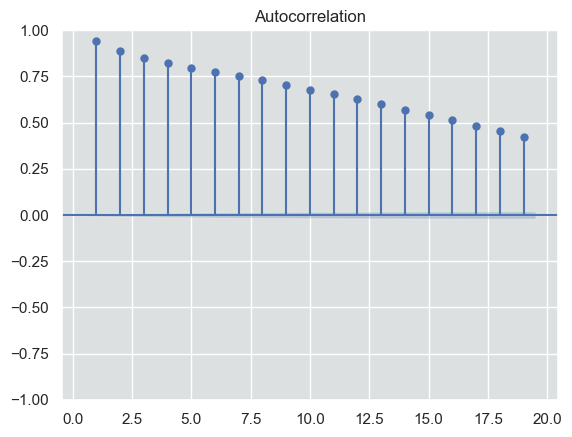

In [1393]:
from statsmodels.graphics.tsaplots import plot_acf

#look for best lag features (wait times at previous time stamps): trying out t-1 to t-20 (up to 5 hours before)
plot_acf(waittimes['SPOSTMIN'], lags=range(1, 20))
plt.savefig('Autocorrelation.png', dpi=300)

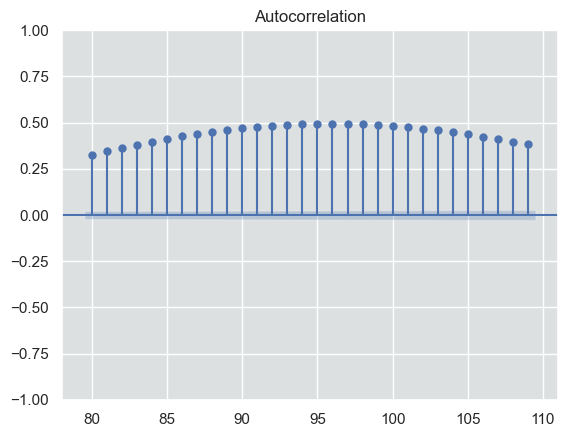

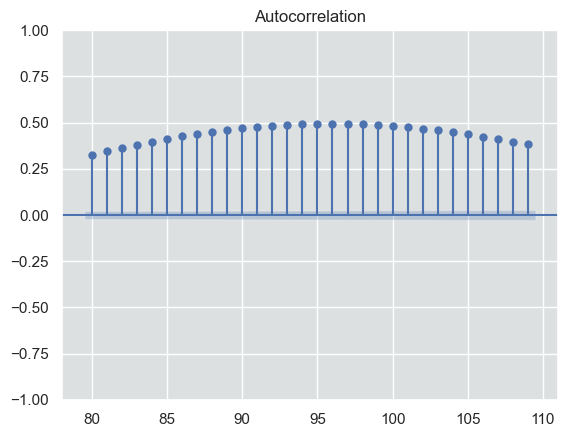

In [1394]:
#approximately 1 day before
plot_acf(waittimes['SPOSTMIN'], lags=range(80, 110))

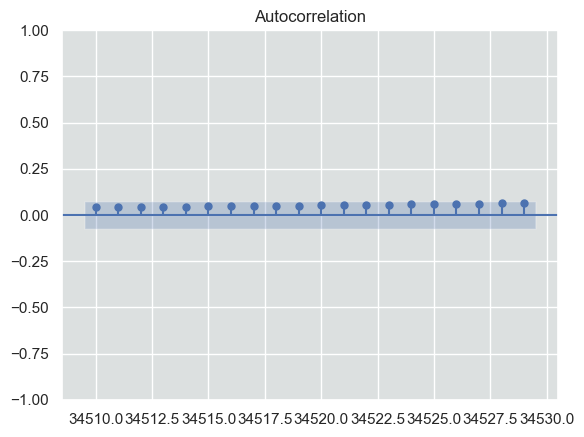

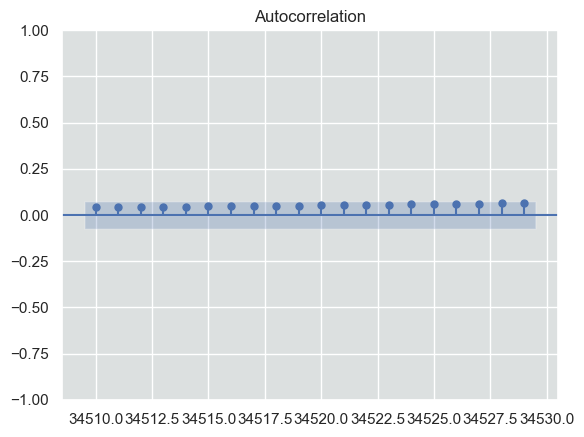

In [1395]:
#approximately 1 year before
plot_acf(waittimes["SPOSTMIN"], lags=range(34510, 34530))

In [1396]:
#decision due to use case: use t-6 as lag feature
waittimes_lagged = copy.deepcopy(waittimes)
waittimes_lagged["SPOSTMINLAG"] = waittimes_lagged["SPOSTMIN"].shift(6)
#drop first six rows due to NaN in new SPOSTMINLAG column
waittimes_lagged = waittimes_lagged.iloc[6:].reset_index()
waittimes_lagged[["SPOSTMIN", "SPOSTMINLAG"]].head(7)

,SPOSTMIN,SPOSTMINLAG
0,30.0,10.0
1,40.0,10.0
2,35.0,15.0
3,32.5,20.0
4,30.0,25.0
5,35.0,25.0
6,37.5,30.0


In [1397]:
X = waittimes_lagged.loc[:, waittimes_lagged.columns != "SPOSTMIN"]
X = X.loc[:, (X.columns != "datetime") & (X.columns != "index")]
y = np.array(waittimes_lagged["SPOSTMIN"])
X.shape, y.shape

((174015, 277), (174015,))

In [1398]:
# cross-validation splits
all_splits_lag = list(ts_cv.split(X, y))
train_0, test_0 = all_splits_lag[0]
#inspect first split
X.iloc[test_0]

,YEAR,MONTHOFYEAR,DAYOFMONTH,HOUROFDAY,MINUTEOFHOUR,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,onehotencoder__x0_nan,onehotencoder__x1_CHRISTMAS,...,MKFIRET1,MKFIRET2,EPFIREWK,EPFIRET1,EPFIRET2,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2,SPOSTMINLAG
69603,2017,3,5,17,60,0.0,0.0,1.0,0.0,0.0,...,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5,50.0
69604,2017,3,5,18,0,0.0,0.0,1.0,0.0,0.0,...,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5,52.5
69605,2017,3,5,18,10,0.0,0.0,1.0,0.0,0.0,...,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5,55.0
69606,2017,3,5,18,20,0.0,0.0,1.0,0.0,0.0,...,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5,50.0
69607,2017,3,5,18,30,0.0,0.0,1.0,0.0,0.0,...,20.000000,100.65,1,21.0,100.65,0,2,19.25,20.5,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104402,2018,3,18,19,10,1.0,0.0,0.0,0.0,0.0,...,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0,50.0
104403,2018,3,18,19,20,1.0,0.0,0.0,0.0,0.0,...,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0,50.0
104404,2018,3,18,19,30,1.0,0.0,0.0,0.0,0.0,...,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0,40.0
104405,2018,3,18,19,40,1.0,0.0,0.0,0.0,0.0,...,20.916667,100.65,1,21.0,100.65,0,2,20.75,22.0,40.0


In [1399]:
rf_pipe5 = Pipeline(
   [('random_forest', RandomForestRegressor(n_estimators=15, max_depth=70, random_state=42))]
)

rf_pipe5.fit(X.iloc[train_0], y[train_0])
preds_rf5 = rf_pipe5.predict(X.iloc[test_0])
evaluate(rf_pipe5, X, y, cv=ts_cv)

R_squared:   -0.646 +/- 0.028
RMSE:        12.096 +/- 0.845


In [1400]:
#Barplot showing relative random forest feature importance (CV Split 1)
#top 10 features
rand = RandomForestRegressor(n_estimators=15, max_depth=70, random_state=42)
rand.fit(X.iloc[train_0], y[train_0])
top10_indeces = rand.feature_importances_.argsort()[-10:]
#get column names
feature_names = list(X.columns[top10_indeces])

colors = sns.color_palette(palette="rocket", n_colors=len(feature_names))
fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(feature_names, rand.feature_importances_[top10_indeces], width= 0.4, color = colors , zorder=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Relative Feature Importance", weight='bold')
ax.set_xlabel("Feature Names", weight='bold')
ax.set_title("Top 10 Features Random Forest", pad=5, color='#333333', weight='bold', loc='left')
plt.xticks(rotation=50, ha='right')
ax.yaxis.grid(True, color='#b0b0b0', zorder=0)
ax.bar_label(bars, fmt='%.4f', padding=5)

KeyboardInterrupt: 

In [1401]:
boost_pipe5 = Pipeline(
   [('boost', HistGradientBoostingRegressor(random_state=42))]
)

boost_pipe5.fit(X.iloc[train_0], y[train_0])
preds_boost5 = boost_pipe5.predict(X.iloc[test_0])
evaluate(boost_pipe5, X, y, cv=ts_cv)

R_squared:   -0.683 +/- 0.017
RMSE:        11.470 +/- 0.934


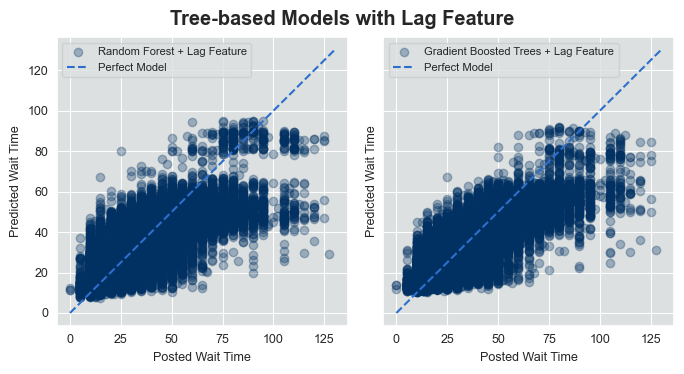

In [ ]:
#Plot prediction error: posted vs predicted wait time
fig, axes = plt.subplots(ncols=2, figsize=(7, 4), sharey=True)
fig.suptitle("Tree-based Models with Lag Feature", weight='bold', y=0.93)
predictions = [preds_rf5, preds_boost5]

labels = ["Random Forest + Lag Feature", "Gradient Boosted Trees + Lag Feature"]

for ax, pred, label in zip(axes, predictions, labels):
    ax.tick_params(axis='both', which='major', labelsize=9, pad=0)
    ax.scatter(y[test_0], pred, alpha=0.3, label=label, color='#013163', edgecolors=None)
    ax.plot([0, 130], [0, 130], "--", label="Perfect Model", color='#2d6fcc')
    ax.set_xlabel("Posted Wait Time", fontsize=9)
    ax.set_ylabel("Predicted Wait Time", fontsize=9)
    ax.grid(linewidth=0.8)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('Plot4.png', dpi=300)
plt.show()

In [ ]:
lr_pipe5 = Pipeline(
   [('linear', LinearRegression())]
)

lr_pipe5.fit(X.iloc[train_0], y[train_0])
preds_lr5 = lr_pipe5.predict(X.iloc[test_0])
evaluate(lr_pipe5, X, y, cv=ts_cv)

R_squared:   -0.036 +/- 0.676
RMSE:        19.338 +/- 8.310
